<a href="https://colab.research.google.com/github/ZeyadSabbah/TrivagoRecommenderSystem/blob/master/TrivagoFeatureEngineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction**  
This file applies feature engineering from the primary data. Features are generated in two forms which are global and local.
The local features are the ones obtained from the session of each user such as the amount of time the user was interacting with an item.
The global features are the ones obtained from all the sessions like the average price of a hotel in the whole data set.

**Generating More Data**  
What differs the most is the Final Clickout, but what if the customer wanted to book more than one hotel in the same country as they are going to have a long trip, so for the same session and different values of the cities the items are being looked up by the user, there is a high chance that the user is satisfies with the final item they selected in the each city. Data used can be increased by considering the final clickout in the other cities besides the final city.  
More data will be generated by seperating the one session the number of subsessions in case the session contains more than one clickout in different cities, and will be treated as totally different sessions for the same user.

## Mounting to Drive

In [8]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Trivago/Project/TrivagoRecommenderSystem

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Trivago/Project/TrivagoRecommenderSystem


## Loading Libraries & Datasets

In [0]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import math
import matplotlib.pyplot as plt
from datetime import datetime
import re
import random
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA

In [0]:
item_metadata_filepath = '../TrivagoRecommenderSystem1/Datasets/raw_data/item_metadata.csv'
item_metadata = pd.read_csv(item_metadata_filepath)

train_filepath = '../TrivagoRecommenderSystem1/Datasets/raw_data/Sets/train.csv'
train = pd.read_csv(train_filepath)

## Feature Engineering Train Data

In [0]:
train.head()

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
0,00RL8Z82B2Z1,aff3928535f48,1541037460,1,search for poi,Newtown,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
1,00RL8Z82B2Z1,aff3928535f48,1541037522,2,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
2,00RL8Z82B2Z1,aff3928535f48,1541037522,3,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
3,00RL8Z82B2Z1,aff3928535f48,1541037532,4,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
4,00RL8Z82B2Z1,aff3928535f48,1541037532,5,interaction item image,109038,AU,"Sydney, Australia",mobile,NaN,NaN,NaN


### Important Dataframes Preparation

While global feature engineering, most work will be dealing with either clickouts or final clickouts instances, helping dataframes will be created for that purpose.  
In order to get representative global values to the items, duplications must be removed. Rows would not all be duplicated because of some attributes such as timestamp, reference, and step.

In [0]:
ClickoutDF = train[train.action_type=='clickout item']
FinalClickoutDF = train[train.action_type=='clickout item'].groupby('session_id').tail(1)
ClickoutUniqueDF = ClickoutDF.drop_duplicates(subset=['session_id', 'impressions'], keep='first')

### Item Global Features

#### No of Times in Impressions
The purpose of this feature is to check how many times an item had been shown to users in the list.

Finding number of times an item has been mentioned in a list.

In [0]:
AllImpressionsList = ClickoutUniqueDF.impressions.apply(lambda x:x.split('|'))

AllImpressionsFlatList = []
for sublist in AllImpressionsList:
    for item in sublist:
        AllImpressionsFlatList.append(item)

InImpressionsCounter = Counter(AllImpressionsFlatList)
InImpressionsDF = pd.DataFrame.from_dict(InImpressionsCounter, orient='index').reset_index()\
                              .rename(columns={'index':'item_id', 0:'NumberInImpressions'})
InImpressionsDF.head(2)

,item_id,NumberInImpressions
0,3400638,394
1,1253714,74


In [0]:
InImpressionsDF.item_id.nunique(), len(InImpressionsDF), item_metadata.item_id.nunique()

(777243, 777243, 927142)

Number of items in this dataframe is less than the number of items in item_metadata, that's because some of the items had not been mentioned in the impressions list.

In [0]:
item_metadata.item_id = item_metadata.item_id.apply(lambda x: str(x))
item_metadata.drop(columns='properties', inplace=True)

#left joining
item_metadata = item_metadata.merge(InImpressionsDF, on='item_id', how='left')
item_metadata.head(2)

,item_id,NumberOfProperties,NumberInImpressions
0,5101,62,68.0
1,5416,46,58.0


#### No of Times in Reference
The purpose of this feature is to check how many times an item has been mentioned in the Reference attribute in the whole train set. 

In [0]:
InReferencesCounter = Counter(train.reference.values.tolist())
InReferencesDF = pd.DataFrame.from_dict(InReferencesCounter, orient='index').reset_index()\
                              .rename(columns={'index':'item_id', 0:'NumberInReferences'})

InReferencesDF.head(2)

,item_id,NumberInReferences
0,Newtown,13
1,666856,23


In [0]:
#left joining
item_metadata = item_metadata.merge(InReferencesDF, on='item_id', how='left')
item_metadata.head(2)

,item_id,NumberOfProperties,NumberInImpressions,NumberInReferences
0,5101,62,68.0,9.0
1,5416,46,58.0,41.0


#### No of Times in Clickout
The purpose of this feature is to check how many times an item has been clicked out

In [0]:
InClickoutCounter = Counter(ClickoutDF.reference.values.tolist())
InClickoutDF = pd.DataFrame.from_dict(InClickoutCounter, orient='index').reset_index()\
                              .rename(columns={'index':'item_id', 0:'NumberAsClickout'})
InClickoutDF.head(2)

,item_id,NumberAsClickout
0,109038,45
1,1257342,19


In [0]:
#left joining
item_metadata = item_metadata.merge(InClickoutDF, on='item_id', how='left')
item_metadata.head(2)

,item_id,NumberOfProperties,NumberInImpressions,NumberInReferences,NumberAsClickout
0,5101,62,68.0,9.0,4.0
1,5416,46,58.0,41.0,6.0


#### No of Time in Final Clickout
The purpose of this feature is to get the number of times an item had been mentioned as a final clickout.

In [0]:
InFinalClickoutCounter = Counter(FinalClickoutDF.reference.values.tolist())
InFinalClickoutDF = pd.DataFrame.from_dict(InFinalClickoutCounter, orient='index').reset_index()\
                              .rename(columns={'index':'item_id', 0:'NumberAsFinalClickout'})
InFinalClickoutDF.head(2)

,item_id,NumberAsFinalClickout
0,1257342,6
1,2795374,15


In [0]:
#left joining
item_metadata = item_metadata.merge(InFinalClickoutDF, on='item_id', how='left')
item_metadata.head(2)

,item_id,NumberOfProperties,NumberInImpressions,NumberInReferences,NumberAsFinalClickout
0,5101,62,68.0,9.0,2.0
1,5416,46,58.0,41.0,2.0


The next step would be dividing the NumberAsFinalClickout by the other 3, in order to get FinalClickout Relativity

#### Final Clickout To Impressions
The purpose of this feature is to get item's rate of clicking out when listed to the user.

In [0]:
FClickoutToImpressions = item_metadata.NumberAsFinalClickout/item_metadata.NumberInImpressions
FClickoutToImpressions.head(2)

0    0.029412
1    0.034483
dtype: float64

In [0]:
#adding attribute
item_metadata['FClickoutToImpressions'] = FClickoutToImpressions
item_metadata.head(2)

,item_id,NumberOfProperties,NumberInImpressions,NumberInReferences,NumberAsFinalClickout,FClickoutToImpressions
0,5101,62,68.0,9.0,2.0,0.029412
1,5416,46,58.0,41.0,2.0,0.034483


#### Final Clickout To References
The purpose of this feature is to get item's rate of clicking out when it was interacted with.

In [0]:
FClickoutToReferences = item_metadata.NumberAsFinalClickout/item_metadata.NumberInReferences
FClickoutToReferences.head(2)

0    0.222222
1    0.048780
dtype: float64

In [0]:
#adding attribute
item_metadata['FClickoutToReferences'] = FClickoutToReferences
item_metadata.head(2)

,item_id,NumberOfProperties,NumberInImpressions,NumberInReferences,NumberAsFinalClickout,FClickoutToImpressions,FClickoutToReferences
0,5101,62,68.0,9.0,2.0,0.029412,0.222222
1,5416,46,58.0,41.0,2.0,0.034483,0.048780


#### Final Clickout To Clickout
The purpose of this feature is to get item's rate of clickout when it was clicked out before.

In [0]:
FClickoutToClickout = item_metadata.NumberAsFinalClickout/item_metadata.NumberAsClickout
FClickoutToClickout.head(2)

In [0]:
#adding attribute
item_metadata['FClickoutToClickout'] = FClickoutToClickout
item_metadata.head(2)

#### Item's Average Rank
The purpose of this feature is to get item's position in the list provided to the user across the train set.  
Since the purpose is to get the average rank across the lists shown to users, an important notice which is that some sessions have different reference and click outs, which provides the same impression list. Duplicated impressions lists in each session should be dropped. (Same thing applies to price as well.)

In [0]:
# using All Clickout dataframe, but the one with the unique impressions for each session for this feature
ClickoutUniqueDF.head(1)

In [0]:
SessionImpressionsDF = ClickoutUniqueDF[['session_id', 'impressions']]
SessionImpressionsDF.impressions = SessionImpressionsDF.impressions.apply(lambda x: x.split('|'))
SessionImpressionsDF.impressions.head(2)

In [0]:
SessionImpressionsDF_exploded = SessionImpressionsDF.explode('impressions')
SessionImpressionsDF_exploded = SessionImpressionsDF_exploded.rename(columns={'impressions':'item_id'})
SessionImpressionsDF_exploded.head(2)

In [0]:
#creating a rank column
rank = SessionImpressionsDF.impressions.apply(lambda x: list(range(1, (len(x) + 1))))
SessionRankDF = pd.concat([SessionImpressionsDF.session_id, rank], axis=1)
SessionRankDF = SessionRankDF.rename(columns={'impressions':'rank'})
SessionRankDF_exploded = SessionRankDF.explode('rank')
SessionRankDF_exploded.head(2)

In [0]:
#creating dataframe that combines both items and rank
ItemRankDF = pd.DataFrame({'item_id':SessionImpressionsDF_exploded['item_id'].values.tolist(),
                            'rank':SessionRankDF_exploded['rank'].values.tolist()})
ItemRankDF.head(2)

In [0]:
#getting the mean of ranks for each item
ItemAverageRank = ItemRankDF.groupby('item_id', sort=False)['rank'].mean().to_frame().reset_index()
ItemAverageRank = ItemAverageRank.rename(columns={'rank':'MeanRank'})
ItemAverageRank.head(2)

In [0]:
#left joining
item_metadata = item_metadata.merge(ItemAverageRank, on='item_id', how='left')
item_metadata.head(2)

#### Item's Average Price
The purpose of this feature is to get item's average price accross the train set.  
Making sure that the length of each impressions list is as the same length of the prices list.

In [0]:
ImpressionsLength = ClickoutUniqueDF.impressions.apply(lambda x: x.split('|')).apply(lambda x: len(x))
PricesLength = ClickoutUniqueDF.prices.apply(lambda x: x.split('|')).apply(lambda x: len(x))
ImpressionsLength.equals(PricesLength)

In [0]:
SessionPricesDF = ClickoutUniqueDF[['session_id', 'prices']]
SessionPricesDF.prices = SessionPricesDF.prices.apply(lambda x: x.split('|'))
SessionPricesDF_exploded = SessionPricesDF.explode('prices')
ItemPriceDF = pd.DataFrame({'item_id':SessionImpressionsDF_exploded.item_id.values.tolist(),
                            'price':SessionPricesDF_exploded.prices.values.tolist()})
ItemPriceDF.head(2)

In [0]:
ItemPriceDF.price = ItemPriceDF.price.apply(lambda x: int(x))
ItemAveragePriceDF = ItemPriceDF.groupby('item_id', sort=False)['price'].mean().to_frame().reset_index()
ItemAveragePriceDF = ItemAveragePriceDF.rename(columns={'price':'MeanPrice'})
ItemAveragePriceDF.head(2)

In [0]:
item_metadata = item_metadata.merge(ItemAveragePriceDF, on='item_id', how='left')
item_metadata.head(2)

,item_id,NumberOfProperties,NumberInImpressions,NumberInReferences,NumberAsClickout,NumberAsFinalClickout,FClickoutToImpressions,FClickoutToReferences,FClickoutToClickout,MeanRank,MeanPrice
0,5101,62,68.0,9.0,4.0,2.0,0.029412,0.222222,0.500000,13.235294,121.617647
1,5416,46,58.0,41.0,6.0,2.0,0.034483,0.048780,0.333333,10.431034,102.913793


#### Item's Maximum Price

In [0]:
ItemMaximumPriceDF = ItemPriceDF.groupby('item_id', sort=False)['price'].max().to_frame().reset_index()
ItemMaximumPriceDF = ItemMaximumPriceDF.rename(columns={'price':'MaxPrice'})
ItemMaximumPriceDF.head(2)

,item_id,MaxPrice
0,3400638,2523
1,1253714,248


In [0]:
#left joining
item_metadata = item_metadata.merge(ItemMaximumPriceDF, on='item_id', how='left')
item_metadata.head(2)

,item_id,NumberOfProperties,NumberInImpressions,NumberInReferences,NumberAsClickout,NumberAsFinalClickout,FClickoutToImpressions,FClickoutToReferences,FClickoutToClickout,MeanRank,MeanPrice,MaxPrice
0,5101,62,68.0,9.0,4.0,2.0,0.029412,0.222222,0.500000,13.235294,121.617647,241.0
1,5416,46,58.0,41.0,6.0,2.0,0.034483,0.048780,0.333333,10.431034,102.913793,270.0


#### Item's Minimum Price

In [0]:
ItemMinimumPriceDF = ItemPriceDF.groupby('item_id', sort=False)['price'].min().to_frame().reset_index()
ItemMinimumPriceDF = ItemMinimumPriceDF.rename(columns={'price':'MinPrice'})
ItemMinimumPriceDF.head(2)

,item_id,MinPrice
0,3400638,68
1,1253714,50


In [0]:
#left joining
item_metadata = item_metadata.merge(ItemMinimumPriceDF, on='item_id', how='left')
item_metadata.head(2)

,item_id,NumberOfProperties,NumberInImpressions,NumberInReferences,NumberAsClickout,NumberAsFinalClickout,FClickoutToImpressions,FClickoutToReferences,FClickoutToClickout,MeanRank,MeanPrice,MaxPrice,MinPrice
0,5101,62,68.0,9.0,4.0,2.0,0.029412,0.222222,0.500000,13.235294,121.617647,241.0,64.0
1,5416,46,58.0,41.0,6.0,2.0,0.034483,0.048780,0.333333,10.431034,102.913793,270.0,59.0


#### Price Rank
The purpose of this feature is to get the average price rank of an item across the train set. Sorting the items not by what is being showed to the user, but by the items' prices, getting the average price rank for each item across the whole train. It shows where an item stands from its peers.  
By using the argsort function, the price rank can be feature can be engineered.

In [0]:
ClickoutDF.prices[13]

'95|66|501|112|95|100|101|72|82|56|56|143|70|25|71|162|73|143|188|118|77|131|143|49|165'

In [0]:
np.argsort(list(map(int, ClickoutDF.prices[13].split('|'))))

array([13, 23,  9, 10,  1, 12, 14,  7, 16, 20,  8,  0,  4,  5,  6,  3, 19,
       21, 17, 22, 11, 15, 24, 18,  2])

In [0]:
SessionPricesDF['PriceRank'] = SessionPricesDF.prices.apply(lambda x: (list(map(int, x))))\
                                                     .apply(lambda x: np.argsort(x))
SessionPricesDF.head(2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,session_id,prices,PriceRank
13,aff3928535f48,"[95, 66, 501, 112, 95, 100, 101, 72, 82, 56, 5...","[13, 23, 9, 10, 1, 12, 14, 7, 16, 20, 8, 0, 4,..."
15,aff3928535f48,"[162, 25, 150, 143, 101, 49, 118, 131, 18, 100...","[8, 1, 15, 5, 12, 16, 20, 9, 4, 10, 23, 24, 6,..."


In [0]:
SessionPricesRankDF = SessionPricesDF[['session_id', 'PriceRank']].explode('PriceRank')
SessionPricesRankDF.head(2)

,session_id,PriceRank
13,aff3928535f48,13
13,aff3928535f48,23


In [0]:
ItemPriceRankDF = pd.DataFrame({'item_id':SessionImpressionsDF_exploded.item_id.values.tolist(),
                            'PriceRank':SessionPricesRankDF.PriceRank.values.tolist()})
ItemPriceRankDF.head(2)

,item_id,PriceRank
0,3400638,13
1,1253714,23


In [0]:
#getting the average price rank of each item
ItemAveragePriceRankDF = ItemPriceRankDF.groupby('item_id', sort=False).PriceRank.mean().to_frame().reset_index()
ItemAveragePriceRankDF = ItemAveragePriceRankDF.rename(columns={'PriceRank':'AveragePriceRank'})
ItemAveragePriceRankDF.head(2)

,item_id,AveragePriceRank
0,3400638,11.901015
1,1253714,10.770270


In [0]:
# left joining
item_metadata = item_metadata.merge(ItemAveragePriceRankDF, on='item_id', how='left')
item_metadata.head(2)

,item_id,NumberOfProperties,NumberInImpressions,NumberInReferences,NumberAsClickout,NumberAsFinalClickout,FClickoutToImpressions,FClickoutToReferences,FClickoutToClickout,MeanRank,MeanPrice,MaxPrice,MinPrice,AveragePriceRank
0,5101,62,68.0,9.0,4.0,2.0,0.029412,0.222222,0.500000,13.235294,121.617647,241.0,64.0,12.985294
1,5416,46,58.0,41.0,6.0,2.0,0.034483,0.048780,0.333333,10.431034,102.913793,270.0,59.0,11.327586


In [0]:
#filling NaN values with zeros
item_metadata = item_metadata.fillna(0)

GlobalItemFeatures = item_metadata.merge(properties_encodedDF, on='item_id', how='left')
GlobalItemFeatures.head(2)

,item_id,NumberOfProperties,NumberInImpressions,NumberInReferences,NumberAsClickout,NumberAsFinalClickout,FClickoutToImpressions,FClickoutToReferences,FClickoutToClickout,MeanRank,MeanPrice,MaxPrice,MinPrice,AveragePriceRank,1 Star,2 Star,3 Star,4 Star,5 Star,Accessible Hotel,Accessible Parking,Adults Only,Air Conditioning,Airport Hotel,Airport Shuttle,All Inclusive (Upon Inquiry),Balcony,Bathtub,Beach,Beach Bar,Beauty Salon,Bed & Breakfast,Bike Rental,Boat Rental,Body Treatments,Boutique Hotel,Bowling,Bungalows,Business Centre,Business Hotel,...,Sailing,Satellite TV,Satisfactory Rating,Sauna,Self Catering,Senior Travellers,Serviced Apartment,Shooting Sports,Shower,Singles,Sitting Area (Rooms),Ski Resort,Skiing,Solarium,Spa (Wellness Facility),Spa Hotel,Steam Room,Sun Umbrellas,Surfing,Swimming Pool (Bar),Swimming Pool (Combined Filter),Swimming Pool (Indoor),Swimming Pool (Outdoor),Szep Kartya,Table Tennis,Telephone,Teleprinter,Television,Tennis Court,Tennis Court (Indoor),Terrace (Hotel),Theme Hotel,Towels,Very Good Rating,Volleyball,Washing Machine,Water Slide,Wheelchair Accessible,WiFi (Public Areas),WiFi (Rooms)
0,5101,62,68.0,9.0,4.0,2.0,0.029412,0.222222,0.500000,13.235294,121.617647,241.0,64.0,12.985294,0,0,0,1,0,1,1,0,1,0,1,0,1,1,0,0,0,0,1,0,0,0,1,0,1,1,...,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,0,0,0,0,0,0,0,1,1
1,5416,46,58.0,41.0,6.0,2.0,0.034483,0.048780,0.333333,10.431034,102.913793,270.0,59.0,11.327586,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,...,0,1,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,1,1


### Item Local Features

#### item_id

In [0]:
def get_data_clickout(data):
  data_clickout = data[data['action_type']=='clickout item'].groupby('session_id').tail(1)
  return data_clickout

def get_item_id(data_clickout):
  item_id = data_clickout[['session_id', 'impressions']]
  item_id['impressions'] = item_id['impressions'].apply(lambda x: x.split('|'))
  item_id = item_id.explode('impressions')
  item_id = item_id.rename(columns={'impressions':'item_id'})
  item_id = item_id.reset_index(drop=True)
  return item_id

In [0]:
FinalClickoutDF = get_data_clickout(train)
item_id = get_item_id(FinalClickoutDF)
item_id

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,session_id,item_id
0,aff3928535f48,55109
1,aff3928535f48,129343
2,aff3928535f48,54824
3,aff3928535f48,2297972
4,aff3928535f48,109014
...,...,...
12586682,62728015bec05,2712342
12586683,62728015bec05,48497
12586684,62728015bec05,11933
12586685,62728015bec05,1714483


#### clickout

In [0]:
def get_clickout(data, data_clickout, item_id):
    clickout = data_clickout[['session_id','reference']]
    clickout = item_id.merge(clickout, on='session_id', how='left')
    clickout['clickout'] = clickout.apply(lambda x: 1 if x['item_id'] == x['reference'] else 0, axis=1)
    clickout.drop(columns='reference', inplace=True)
    clickout = clickout.reset_index(drop=True)
    IndexToNan = data_clickout.reference.index.values.tolist()
    data.loc[IndexToNan, 'reference'] = np.nan
    return clickout, data

In [0]:
clickout, train = get_clickout(train, FinalClickoutDF, item_id)
clickout.head(10)

,session_id,item_id,clickout
0,aff3928535f48,55109,0
1,aff3928535f48,129343,0
2,aff3928535f48,54824,0
3,aff3928535f48,2297972,0
4,aff3928535f48,109014,0
5,aff3928535f48,1257342,1
6,aff3928535f48,1031578,0
7,aff3928535f48,109018,0
8,aff3928535f48,1332971,0
9,aff3928535f48,666916,0


#### price

In [0]:
def get_price(data_clickout):
  price = data_clickout[['session_id', 'prices']]
  price['prices'] = price['prices'].apply(lambda x: x.split('|'))
  price = price.explode('prices')
  price['prices'] = price['prices'].apply(lambda x: int(x))
  price = price.rename(columns={'prices':'price'})
  price = price.reset_index(drop=True)
  return price

In [0]:
price = get_price(FinalClickoutDF)
price

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,session_id,price
0,aff3928535f48,162
1,aff3928535f48,25
2,aff3928535f48,150
3,aff3928535f48,143
4,aff3928535f48,101
...,...,...
12586682,62728015bec05,73
12586683,62728015bec05,169
12586684,62728015bec05,87
12586685,62728015bec05,485


#### item_rank

In [0]:
def get_item_rank(data_clickout):
  item_rank = data_clickout[['session_id', 'impressions']]
  item_rank['impressions'] = item_rank['impressions'].apply(lambda x: x.split('|'))
  item_rank['impressions'] = item_rank['impressions'].apply(lambda x: list(range(1, len(x) + 1)))
  item_rank = item_rank.explode('impressions')
  item_rank['impressions'] = item_rank['impressions'].apply(lambda x: int(x))
  item_rank = item_rank.rename(columns={'impressions':'item_rank'})
  item_rank = item_rank.reset_index(drop=True)
  return item_rank

In [0]:
item_rank = get_item_rank(FinalClickoutDF)
item_rank

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,session_id,item_rank
0,aff3928535f48,1
1,aff3928535f48,2
2,aff3928535f48,3
3,aff3928535f48,4
4,aff3928535f48,5
...,...,...
12586682,62728015bec05,21
12586683,62728015bec05,22
12586684,62728015bec05,23
12586685,62728015bec05,24


#### price_rank

In [0]:
def get_price_rank(data):
  price_rank = data.groupby('session_id', sort=False).price.apply(lambda x: x.values).to_frame().reset_index().rename(columns={'price':'price_list'})
  price_rank.price_list = price_rank.price_list.apply(lambda x: np.argsort(x))
  price_rank = price_rank.rename(columns={'price_list':'price_rank'})
  price_rank = price_rank.explode('price_rank')
  price_rank = price_rank.reset_index(drop=True)
  return price_rank

In [0]:
price_rank = get_price_rank(price)
price_rank

,session_id,price_rank
0,aff3928535f48,8
1,aff3928535f48,1
2,aff3928535f48,15
3,aff3928535f48,5
4,aff3928535f48,12
...,...,...
15373343,62728015bec05,6
15373344,62728015bec05,19
15373345,62728015bec05,10
15373346,62728015bec05,23


#### session_duration

In [0]:
def get_session_duration(data, item_id):
  session_duration = data.groupby('session_id', sort=False).timestamp.max() - data.groupby('session_id', sort=False).timestamp.min()
  session_duration = session_duration.to_frame().rename(columns={'timestamp':'session_duration'})
  session_duration = item_id.merge(session_duration, on='session_id', how='left')
  session_duration.drop(columns='item_id', inplace=True)
  session_duration = session_duration.reset_index(drop=True)
  return session_duration

In [0]:
session_duration = get_session_duration(train, item_id)
session_duration

,session_id,session_duration
0,aff3928535f48,1025
1,aff3928535f48,1025
2,aff3928535f48,1025
3,aff3928535f48,1025
4,aff3928535f48,1025
...,...,...
15373343,62728015bec05,571
15373344,62728015bec05,571
15373345,62728015bec05,571
15373346,62728015bec05,571


#### item_duration

In [0]:
def get_item_duration(data, item_id):
  item_duration = data.groupby(['session_id', 'reference'], sort=False).timestamp.max() - data.groupby(['session_id', 'reference'], sort=False).timestamp.min()
  item_duration = item_duration.reset_index().rename(columns={'reference':'item_id', 'timestamp':'item_duration'})
  item_duration = item_id.merge(item_duration, left_on=['session_id', 'item_id'], right_on=['session_id', 'item_id'], how='left')
  item_duration = item_duration.fillna(0)
  item_duration = item_duration.reset_index(drop=True)
  return item_duration

In [0]:
item_duration = get_item_duration(train, item_id)
item_duration[item_duration.item_duration>0]

,session_id,item_id,item_duration
25,3599a6f709eab,2795374,134.0
65,ec139e10b9238,1032816,338.0
79,325fafb5fa450,65685,65.0
126,7157899be2839,2552514,3.0
185,4c6062d7cefe4,138930,10.0
...,...,...,...
15373250,92b7ab1287edf,207081,14.0
15373251,92b7ab1287edf,50584,82.0
15373273,6b66cb0cfb518,3811156,3.0
15373274,6b66cb0cfb518,2337580,10.0


#### item_session_duration

In [0]:
def get_item_session_duration(item_duration, session_duration):
  item_duration['item_session_duration'] = item_duration.item_duration/session_duration.session_duration
  item_session_duration = item_duration[['session_id', 'item_id', 'item_session_duration']]
  item_duration = item_duration[['session_id', 'item_id', 'item_duration']]
  item_session_duration = item_session_duration.fillna(0)
  item_session_druation = item_session_duration.reset_index(drop=True)
  return item_session_duration

In [0]:
item_session_duration = get_item_session_duration(item_duration, session_duration)
item_session_duration[item_session_duration.item_session_duration>0]

,session_id,item_id,item_session_duration
25,3599a6f709eab,2795374,1.000000
65,ec139e10b9238,1032816,0.550489
79,325fafb5fa450,65685,0.256917
126,7157899be2839,2552514,1.000000
185,4c6062d7cefe4,138930,0.080645
...,...,...,...
15373250,92b7ab1287edf,207081,0.009609
15373251,92b7ab1287edf,50584,0.056280
15373273,6b66cb0cfb518,3811156,0.230769
15373274,6b66cb0cfb518,2337580,0.769231


#### item_interactions

In [0]:
def get_item_interactions(data, item_id):
  item_interactions = data.groupby(['session_id', 'reference']).step.count().to_frame().reset_index()
  item_interactions = item_interactions.rename(columns={'reference':'item_id', 'step':'item_interactions'})
  item_interactions = item_id.merge(item_interactions, left_on=['session_id', 'item_id'], right_on=['session_id', 'item_id'], how='left')
  item_interactions = item_interactions.fillna(0)
  item_interactions = item_interactions.reset_index(drop=True)
  return item_interactions

In [0]:
item_interactions = get_item_interactions(train, item_id)
item_interactions[item_interactions.item_interactions>0]

,session_id,item_id,item_interactions
5,aff3928535f48,1257342,1.0
25,3599a6f709eab,2795374,35.0
65,ec139e10b9238,1032816,4.0
79,325fafb5fa450,65685,38.0
82,325fafb5fa450,1320460,1.0
...,...,...,...
15373274,6b66cb0cfb518,2337580,8.0
15373318,e7916050980d9,8985292,1.0
15373323,62728015bec05,6617798,15.0
15373326,62728015bec05,1161323,1.0


#### maximum_step

In [0]:
def get_maximum_step(data, item_id):
  maximum_step = data.groupby('session_id', sort=False).step.max().to_frame().reset_index()
  maximum_step = maximum_step.rename(columns={'step':'maximum_step'})
  maximum_step = item_id.merge(maximum_step, on='session_id', how='left')
  maximum_step = maximum_step.reset_index(drop=True)
  return maximum_step

In [0]:
maximum_step = get_maximum_step(train, item_id)
maximum_step

,session_id,item_id,maximum_step
0,aff3928535f48,55109,16
1,aff3928535f48,129343,16
2,aff3928535f48,54824,16
3,aff3928535f48,2297972,16
4,aff3928535f48,109014,16
...,...,...,...
15373343,62728015bec05,2712342,19
15373344,62728015bec05,48497,19
15373345,62728015bec05,11933,19
15373346,62728015bec05,1714483,19


#### top_list

In [0]:
def get_top_list(item_rank):
  top_list = item_rank[['session_id', 'item_rank']]
  top_list['top_list'] = top_list.apply(lambda x: 1 if x['item_rank'] < 6 else 0, axis=1)
  top_list = top_list.reset_index(drop=True)
  return top_list

In [0]:
top_list = get_top_list(item_rank)
top_list

,session_id,item_rank,top_list
0,aff3928535f48,1,1
1,aff3928535f48,2,1
2,aff3928535f48,3,1
3,aff3928535f48,4,1
4,aff3928535f48,5,1
...,...,...,...
15373343,62728015bec05,21,0
15373344,62728015bec05,22,0
15373345,62728015bec05,23,0
15373346,62728015bec05,24,0


In [0]:
dataframes = [item_id, price, item_rank, price_rank, clickout, session_duration, item_duration, item_session_duration,
              item_interactions, maximum_step, top_list]
local_data = pd.concat(dataframes)
local_data

### Merging Global Features to Local Feautres

In [0]:
GlobalPath = '../TrivagoRecommenderSystem1/Datasets/clean_data/ItemsFeatures/item_global.csv'
LocalPath = '../TrivagoRecommenderSystem1/Datasets/clean_data/ItemsFeatures/item_local.csv'

GlobalData = pd.read_csv(GlobalPath)
LocalData = pd.read_csv(LocalPath)

TrainData = LocalData.merge(GlobalData, on='item_id', how='left')
TrainData

,session_id,item_id,price,item_rank,price_rank,clickout,session_duration,item_duration,item_session_duration,item_interactions,maximum_step,top_list,NumberOfProperties,NumberInImpressions,NumberInReferences,NumberAsClickout,NumberAsFinalClickout,FClickoutToImpressions,FClickoutToReferences,FClickoutToClickout,MeanRank,MeanPrice,MaxPrice,MinPrice,AveragePriceRank
0,aff3928535f48,55109,162,1,8,0,1025,0.0,0.0,0.0,16,1,58.0,584.0,479.0,25.0,11.0,0.018836,0.022965,0.440000,12.239726,194.595890,1905.0,65.0,11.840753
1,aff3928535f48,129343,25,2,1,0,1025,0.0,0.0,0.0,16,1,26.0,108.0,69.0,9.0,4.0,0.037037,0.057971,0.444444,11.083333,72.259259,388.0,18.0,10.166667
2,aff3928535f48,54824,150,3,15,0,1025,0.0,0.0,0.0,16,1,42.0,443.0,386.0,61.0,32.0,0.072235,0.082902,0.524590,11.627540,107.672686,408.0,42.0,11.291196
3,aff3928535f48,2297972,143,4,5,0,1025,0.0,0.0,0.0,16,1,38.0,17.0,23.0,2.0,0.0,0.000000,0.000000,0.000000,13.294118,136.000000,183.0,101.0,9.647059
4,aff3928535f48,109014,101,5,12,0,1025,0.0,0.0,0.0,16,1,60.0,194.0,268.0,18.0,9.0,0.046392,0.033582,0.500000,14.443299,149.329897,628.0,70.0,11.262887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12586682,62728015bec05,2712342,73,21,6,0,571,0.0,0.0,1.0,19,0,33.0,40.0,20.0,2.0,0.0,0.000000,0.000000,0.000000,15.550000,129.525000,881.0,54.0,12.950000
12586683,62728015bec05,48497,169,22,19,0,571,0.0,0.0,0.0,19,0,46.0,101.0,63.0,6.0,2.0,0.019802,0.031746,0.333333,15.049505,141.386139,253.0,99.0,11.940594
12586684,62728015bec05,11933,87,23,10,0,571,0.0,0.0,0.0,19,0,46.0,282.0,269.0,15.0,6.0,0.021277,0.022305,0.400000,14.003546,107.453901,311.0,69.0,12.262411
12586685,62728015bec05,1714483,485,24,23,0,571,0.0,0.0,0.0,19,0,37.0,49.0,7.0,1.0,0.0,0.000000,0.000000,0.000000,15.612245,287.734694,586.0,141.0,12.510204


Checking for NaN values

In [0]:
TrainData[TrainData.MeanRank.isnull()]

,session_id,item_id,price,item_rank,price_rank,clickout,session_duration,item_duration,item_session_duration,item_interactions,maximum_step,top_list,NumberOfProperties,NumberInImpressions,NumberInReferences,NumberAsClickout,NumberAsFinalClickout,FClickoutToImpressions,FClickoutToReferences,FClickoutToClickout,MeanRank,MeanPrice,MaxPrice,MinPrice,AveragePriceRank
4369,eff296130596e,5814172,23,25,5,0,33,0.0,0.0,0.0,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4996,a1c2a8bad7e09,8964532,132,22,21,0,288,0.0,0.0,0.0,8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9317,fe0c86b72bf1e,5786780,140,23,16,0,0,0.0,0.0,0.0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11239,330b8df67f204,4466176,31,7,6,0,1799,0.0,0.0,0.0,12,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14070,003c9a4b892fa,8576928,270,5,6,0,60,0.0,0.0,0.0,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12581083,a541d7ae86dc3,9301238,27,8,7,0,102,0.0,0.0,0.0,11,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12581460,d4a08da70ef00,8994580,45,8,3,0,48,0.0,0.0,0.0,8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12582529,48749a0235b0b,11249888,22,24,24,0,110,0.0,0.0,0.0,13,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12583747,69f6a3d291979,9424218,88,19,18,0,3456,0.0,0.0,0.0,13,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Checking the reason for the NaN values.

In [0]:
len(set(TrainData.item_id.unique()) - set(item_metadata.item_id.unique()))

674

Although item_metadata should have all the items in the training set, 706 of the items don't exits in item_metadata dataset. NaN values will be filled with mean value of each attribute.  
These NaN values will be replaced with mean value of each column.

In [0]:
NaNcolumns = []
for col in TrainData.columns:
  if TrainData.isna().any()[col]==True:
    NaNcolumns.append(col)

for column in NaNcolumns:
  MeanValue = TrainData[column].mean()
  TrainData[column] =  TrainData[column].fillna(MeanValue)

TrainData[TrainData.MeanRank.isnull()]

,session_id,item_id,price,item_rank,price_rank,clickout,session_duration,item_duration,item_session_duration,item_interactions,maximum_step,top_list,NumberOfProperties,NumberInImpressions,NumberInReferences,NumberAsClickout,NumberAsFinalClickout,FClickoutToImpressions,FClickoutToReferences,FClickoutToClickout,MeanRank,MeanPrice,MaxPrice,MinPrice,AveragePriceRank


All above functions in the above cells are defined in one function in a class in order to make the code reusable for validation and test sets. The class is called data_transformation, and the main function in the class is transform_data(data), and takes only the Pandas Dataframe as an input, and gives the ready data for standardizing and then processing.

### Applying transform_data Function

All the functions are saved in a class that can be imported and apply the function in just one line.

In [0]:
from data_transformation import data_transformation

TrainData = data_transformation.transform_data(train)
TrainData

/content/drive/My Drive/Trivago/Project/TrivagoRecommenderSystem/data_transformation.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item_id['impressions'] = item_id['impressions'].apply(lambda x: x.split('|'))
/content/drive/My Drive/Trivago/Project/TrivagoRecommenderSystem/data_transformation.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['prices'] = price['prices'].apply(lambda x: x.split('|'))
/content/drive/My Drive/Trivago/Project/TrivagoRecommenderSystem/data_transformation.py:44: Se

,session_id,item_id,price,item_rank,price_rank,clickout,session_duration,item_duration,item_session_duration,item_interactions,maximum_step,top_list,NumberOfProperties,NumberInImpressions,NumberInReferences,NumberAsClickout,NumberAsFinalClickout,FClickoutToImpressions,FClickoutToReferences,FClickoutToClickout,MeanRank,MeanPrice,MaxPrice,MinPrice,AveragePriceRank
0,aff3928535f48,55109,162,1,8,0,1025,0.0,0.0,0.0,16,1,58.0,584.0,479.0,25.0,11.0,0.018836,0.022965,0.440000,12.239726,194.595890,1905.0,65.0,11.840753
1,aff3928535f48,129343,25,2,1,0,1025,0.0,0.0,0.0,16,1,26.0,108.0,69.0,9.0,4.0,0.037037,0.057971,0.444444,11.083333,72.259259,388.0,18.0,10.166667
2,aff3928535f48,54824,150,3,15,0,1025,0.0,0.0,0.0,16,1,42.0,443.0,386.0,61.0,32.0,0.072235,0.082902,0.524590,11.627540,107.672686,408.0,42.0,11.291196
3,aff3928535f48,2297972,143,4,5,0,1025,0.0,0.0,0.0,16,1,38.0,17.0,23.0,2.0,0.0,0.000000,0.000000,0.000000,13.294118,136.000000,183.0,101.0,9.647059
4,aff3928535f48,109014,101,5,12,0,1025,0.0,0.0,0.0,16,1,60.0,194.0,268.0,18.0,9.0,0.046392,0.033582,0.500000,14.443299,149.329897,628.0,70.0,11.262887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12586682,62728015bec05,2712342,73,21,6,0,571,0.0,0.0,1.0,19,0,33.0,40.0,20.0,2.0,0.0,0.000000,0.000000,0.000000,15.550000,129.525000,881.0,54.0,12.950000
12586683,62728015bec05,48497,169,22,19,0,571,0.0,0.0,0.0,19,0,46.0,101.0,63.0,6.0,2.0,0.019802,0.031746,0.333333,15.049505,141.386139,253.0,99.0,11.940594
12586684,62728015bec05,11933,87,23,10,0,571,0.0,0.0,0.0,19,0,46.0,282.0,269.0,15.0,6.0,0.021277,0.022305,0.400000,14.003546,107.453901,311.0,69.0,12.262411
12586685,62728015bec05,1714483,485,24,23,0,571,0.0,0.0,0.0,19,0,37.0,49.0,7.0,1.0,0.0,0.000000,0.000000,0.000000,15.612245,287.734694,586.0,141.0,12.510204


## Feature Engineering More Train Data

In [0]:
trainMoreFClickout = train[train.action_type=='clickout item'].groupby('session_id')
trainMoreFClickout = (trainMoreFClickout.city.nunique()>1).to_frame().rename(columns={'city':'MoreFClickout'}).reset_index()
trainMoreFClickout = trainMoreFClickout[trainMoreFClickout.MoreFClickout==True]
trainMoreFClickout = train[train.session_id.isin(trainMoreFClickout.session_id.tolist())]
MoreFClickout = trainMoreFClickout[trainMoreFClickout.action_type=='clickout item'].groupby(['session_id', 'city']).tail(1)
MoreFClickout.head(3)

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
947,1R2O77QTOU5A,484dfe03115ba,1541035374,1,clickout item,104770,BR,"Guarulhos, Brazil",desktop,NaN,152560|2454130|104651|104770|104806|104514|142...,42|34|113|54|103|44|43|41|42|45|51|46|20|51|43...
956,1R2O77QTOU5A,484dfe03115ba,1541036981,10,clickout item,NaN,BR,"São Paulo, Brazil",desktop,NaN,104806|478461|6478386|5049198|104651|152560|24...,103|51|41|70|113|42|34|44|42|37|51|42|29|18|46...
2093,4GVU9AT4RVBW,b42f4cd99975e,1541106952,1,clickout item,42161,FR,"Amsterdam, Netherlands",mobile,NaN,921237|42161|42125|9051714|2775026|8435844|421...,89|69|110|126|75|98|61|84|52|96|80|88|57|84|14...


In [0]:
#changening session_id
c = MoreFClickout.groupby('session_id').cumcount()
c = c.replace(0, '').astype(str)
MoreFClickout['session_id'] += c
MoreFClickout.head(3)

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
947,1R2O77QTOU5A,484dfe03115ba,1541035374,1,clickout item,104770,BR,"Guarulhos, Brazil",desktop,NaN,152560|2454130|104651|104770|104806|104514|142...,42|34|113|54|103|44|43|41|42|45|51|46|20|51|43...
956,1R2O77QTOU5A,484dfe03115ba1,1541036981,10,clickout item,NaN,BR,"São Paulo, Brazil",desktop,NaN,104806|478461|6478386|5049198|104651|152560|24...,103|51|41|70|113|42|34|44|42|37|51|42|29|18|46...
2093,4GVU9AT4RVBW,b42f4cd99975e,1541106952,1,clickout item,42161,FR,"Amsterdam, Netherlands",mobile,NaN,921237|42161|42125|9051714|2775026|8435844|421...,89|69|110|126|75|98|61|84|52|96|80|88|57|84|14...


In [0]:
MoreFClickout[['user_id', 'session_id', 'city']]

,user_id,session_id,city
947,1R2O77QTOU5A,484dfe03115ba,"Guarulhos, Brazil"
956,1R2O77QTOU5A,484dfe03115ba1,"São Paulo, Brazil"
2093,4GVU9AT4RVBW,b42f4cd99975e,"Amsterdam, Netherlands"
2100,4GVU9AT4RVBW,b42f4cd99975e1,"Utrecht, Netherlands"
2349,52IZXNUIF0NL,60f16cf8330b7,"Tokyo, Japan"
...,...,...,...
10665708,Y813RRM1N7P2,219a868ad5a611,"Santiago, Chile"
10665804,YIRGODEF6SO6,b8c521849e3c2,"Dortmund, Germany"
10665826,YIRGODEF6SO6,b8c521849e3c21,"Luebeck, Germany"
10665866,Z6W0KZ1LCB8H,a4c049a08e980,"Murray Bridge, Australia"


In [0]:
trainMoreFClickout = trainMoreFClickout.rename(columns={'session_id':'old_session_id'})\
                     .merge(MoreFClickout[['user_id', 'session_id', 'city']], on=['user_id', 'city'], how='left')\
                     .drop(columns='old_session_id')
cols = train.columns.tolist()
trainMoreFClickout = trainMoreFClickout[cols]
trainMoreFClickout.head()

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
0,1R2O77QTOU5A,484dfe03115ba,1541035374,1,clickout item,104770,BR,"Guarulhos, Brazil",desktop,NaN,152560|2454130|104651|104770|104806|104514|142...,42|34|113|54|103|44|43|41|42|45|51|46|20|51|43...
1,1R2O77QTOU5A,484dfe03115ba1,1541036663,2,search for poi,International Airport São Paulo Guarulhos,BR,"São Paulo, Brazil",desktop,NaN,NaN,NaN
2,1R2O77QTOU5A,484dfe03115ba1,1541036711,3,clickout item,104712,BR,"São Paulo, Brazil",desktop,NaN,104806|478461|6478386|5049198|104651|152560|24...,103|51|41|70|113|42|34|44|42|37|51|42|29|18|46...
3,1R2O77QTOU5A,484dfe03115ba1,1541036775,4,clickout item,104770,BR,"São Paulo, Brazil",desktop,NaN,104806|478461|6478386|5049198|104651|152560|24...,103|51|41|70|113|42|34|44|42|37|51|42|29|18|46...
4,1R2O77QTOU5A,484dfe03115ba1,1541036970,5,interaction item rating,104712,BR,"São Paulo, Brazil",desktop,NaN,NaN,NaN


In [0]:
# Concatenating trainMoreFClickout to train
trainMore = pd.concat([train, trainMoreFClickout]).drop_duplicates()
trainMore.head(2)

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
0,00RL8Z82B2Z1,aff3928535f48,1541037460,1,search for poi,Newtown,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
1,00RL8Z82B2Z1,aff3928535f48,1541037522,2,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN


### Applying transform_data Function
All the functions are saved in a class that can be imported and apply the function in just one line.

In [0]:
from data_transformation import data_transformation

TrainMoreData = data_transformation.transform_data(trainMore)
TrainMoreData

/content/drive/My Drive/Trivago/Project/TrivagoRecommenderSystem/data_transformation.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item_id['impressions'] = item_id['impressions'].apply(lambda x: x.split('|'))
/content/drive/My Drive/Trivago/Project/TrivagoRecommenderSystem/data_transformation.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['prices'] = price['prices'].apply(lambda x: x.split('|'))
/content/drive/My Drive/Trivago/Project/TrivagoRecommenderSystem/data_transformation.py:44: Se

,session_id,item_id,price,item_rank,price_rank,clickout,session_duration,item_duration,item_session_duration,item_interactions,maximum_step,top_list,NumberOfProperties,NumberInImpressions,NumberInReferences,NumberAsClickout,NumberAsFinalClickout,FClickoutToImpressions,FClickoutToReferences,FClickoutToClickout,MeanRank,MeanPrice,MaxPrice,MinPrice,AveragePriceRank
0,aff3928535f48,55109,162,1,8,0,1025,0.0,0.000000,0.0,16,1,58.0,584.0,479.0,25.0,11.0,0.018836,0.022965,0.440000,12.239726,194.595890,1905.0,65.0,11.840753
1,aff3928535f48,129343,25,2,1,0,1025,0.0,0.000000,0.0,16,1,26.0,108.0,69.0,9.0,4.0,0.037037,0.057971,0.444444,11.083333,72.259259,388.0,18.0,10.166667
2,aff3928535f48,54824,150,3,15,0,1025,0.0,0.000000,0.0,16,1,42.0,443.0,386.0,61.0,32.0,0.072235,0.082902,0.524590,11.627540,107.672686,408.0,42.0,11.291196
3,aff3928535f48,2297972,143,4,5,0,1025,0.0,0.000000,0.0,16,1,38.0,17.0,23.0,2.0,0.0,0.000000,0.000000,0.000000,13.294118,136.000000,183.0,101.0,9.647059
4,aff3928535f48,109014,101,5,12,0,1025,0.0,0.000000,0.0,16,1,60.0,194.0,268.0,18.0,9.0,0.046392,0.033582,0.500000,14.443299,149.329897,628.0,70.0,11.262887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13192212,a4c049a08e9801,1425092,84,9,3,0,1037,0.0,0.000000,0.0,46,0,36.0,44.0,16.0,2.0,1.0,0.022727,0.062500,0.500000,14.931818,66.772727,156.0,54.0,11.500000
13192213,a4c049a08e9801,1627067,94,10,10,0,1037,13.0,0.012536,2.0,46,0,54.0,126.0,98.0,15.0,9.0,0.071429,0.091837,0.600000,12.349206,97.896825,216.0,59.0,11.031746
13192214,a4c049a08e9801,4201464,143,11,2,0,1037,152.0,0.146577,15.0,46,0,16.0,12.0,17.0,2.0,1.0,0.083333,0.058824,0.500000,15.416667,121.250000,158.0,92.0,8.000000
13192215,a4c049a08e9801,2106906,137,12,0,0,1037,0.0,0.000000,0.0,46,0,32.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,12.000000,137.000000,137.0,137.0,0.000000


In [0]:
TrainMoreData = pd.read_csv('../TrivagoRecommenderSystem1/Datasets/clean_data/Sets/trainMore.csv')

# Items' Properties

#### Item Metadata

In [0]:
item_metadata.properties = item_metadata.properties.apply(lambda x: x.split('|'))
item_metadata['NumberOfProperties'] = item_metadata.properties.apply(lambda x: len(x))
item_metadata.head(2)

,item_id,properties,NumberOfProperties
0,5101,"[Satellite TV, Golf Course, Airport Shuttle, C...",62
1,5416,"[Satellite TV, Cosmetic Mirror, Safe (Hotel), ...",46


In [0]:
#getting total number of unique properties across all items
AllPropertiesList = item_metadata.properties.tolist()

AllPropertiesFlatList = []
for sublist in AllPropertiesList:
    for item in sublist:
        AllPropertiesFlatList.append(item)
        
print('Number of unique properties is', len(set(AllPropertiesFlatList)))

Number of unique properties is 157


The purpose is to convert item_metada from the string form of properties into N-Hot encoded. 

In [0]:
item_metadata.properties = item_metadata.properties.apply(lambda x: tuple(x))

one_hot = MultiLabelBinarizer()
properties_encoded = one_hot.fit_transform(item_metadata.properties.values.tolist())
properties_encodedDF = pd.DataFrame(properties_encoded)

#changing column names
properties_list = one_hot.classes_.tolist()
for i in range(len(properties_list)):
    properties_encodedDF = properties_encodedDF.rename(columns={i:properties_list[i]})

#creating a column of the item id to get the similarity between items
item_metadata.item_id = item_metadata.item_id.apply(lambda x: str(x))
properties_encodedDF['item_id'] = item_metadata.item_id

properties_encodedDF.head()

,1 Star,2 Star,3 Star,4 Star,5 Star,Accessible Hotel,Accessible Parking,Adults Only,Air Conditioning,Airport Hotel,Airport Shuttle,All Inclusive (Upon Inquiry),Balcony,Bathtub,Beach,Beach Bar,Beauty Salon,Bed & Breakfast,Bike Rental,Boat Rental,Body Treatments,Boutique Hotel,Bowling,Bungalows,Business Centre,Business Hotel,Cable TV,Camping Site,Car Park,Casa Rural (ES),Casino (Hotel),Central Heating,Childcare,Club Hotel,Computer with Internet,Concierge,Conference Rooms,Convenience Store,Convention Hotel,Cosmetic Mirror,...,Satellite TV,Satisfactory Rating,Sauna,Self Catering,Senior Travellers,Serviced Apartment,Shooting Sports,Shower,Singles,Sitting Area (Rooms),Ski Resort,Skiing,Solarium,Spa (Wellness Facility),Spa Hotel,Steam Room,Sun Umbrellas,Surfing,Swimming Pool (Bar),Swimming Pool (Combined Filter),Swimming Pool (Indoor),Swimming Pool (Outdoor),Szep Kartya,Table Tennis,Telephone,Teleprinter,Television,Tennis Court,Tennis Court (Indoor),Terrace (Hotel),Theme Hotel,Towels,Very Good Rating,Volleyball,Washing Machine,Water Slide,Wheelchair Accessible,WiFi (Public Areas),WiFi (Rooms),item_id
0,0,0,0,1,0,1,1,0,1,0,1,0,1,1,0,0,0,0,1,0,0,0,1,0,1,1,1,0,1,0,0,1,0,0,1,0,1,0,0,1,...,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,0,0,0,0,0,0,0,1,1,5101
1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,...,1,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,1,1,5416
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,...,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,1,5834
3,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,1,1,1,0,0,1,...,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,0,0,0,0,0,0,0,1,0,5910
4,0,0,0,1,0,1,1,0,0,0,0,0,1,1,1,0,1,0,1,1,1,0,1,0,1,1,1,0,1,0,0,1,0,0,1,0,1,0,1,1,...,1,1,1,0,0,0,0,1,0,1,0,0,1,1,1,1,0,1,0,1,1,1,0,1,1,0,1,1,1,1,0,1,0,1,0,0,1,1,1,6066


Having 158 columns with all can be challenging to have them all in the training data, as the expected instances after feature engineering should be around 12 millions instances. Dimensionality reduction is required in this case.

##### K-means

The whole idea of using k-means is to get clusters of items (hotels and accomodations) which are similar in the properties together, and use one hot encoding to refer to each cluster.

In [0]:
from sklearn.cluster import KMeans

X = properties_encodedDF.drop(columns='item_id')
X = X.values
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)
kmeans.labels_

array([2, 2, 3, ..., 1, 1, 1], dtype=int32)

In [0]:
PropertiesClustersDF = pd.DataFrame({'item_id':properties_encodedDF.item_id.values.tolist(),
                                     'cluster':kmeans.labels_.tolist()})
PropertiesClustersDF.cluster = PropertiesClustersDF.cluster.replace([0, 1, 2, 3, 4], ['A', 'B', 'C', 'D', 'E'])

In [28]:
ClusterDF = pd.get_dummies(PropertiesClustersDF.cluster)
ClusterDF['item_id'] = PropertiesClustersDF.item_id.values.tolist()
ClusterDF.head()

,A,B,C,D,E,item_id
0,0,0,1,0,0,5101
1,0,0,1,0,0,5416
2,0,0,0,1,0,5834
3,0,0,0,1,0,5910
4,0,0,1,0,0,6066


In [0]:
ClusterDF.to_csv('../TrivagoRecommenderSystem1/Datasets/clean_data/ItemsPropertiesSimilarities/PropertiesClusters.csv', index=False)

In [0]:
ClusterDF = pd.read_csv('../TrivagoRecommenderSystem1/Datasets/clean_data/ItemsPropertiesSimilarities/PropertiesClusters.csv')

##### PCA

By using Principal Component Analysis, the most important information can be retained from the 158 by specifying the percentage of accumulative variance required. Scree plot can show which components are the most important to be taken into consideration.

In [0]:
pca = PCA(0.95)
X = properties_encodedDF.drop(columns='item_id')
properties = pca.fit_transform(X)
propertiesDF = pd.DataFrame(data = properties)
propertiesDF.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97
0,4.268394,-1.117515,1.206825,-0.172555,0.081194,-0.669126,1.107799,0.851917,-0.757128,0.792128,0.318026,1.007645,-0.261100,0.041255,-0.502512,0.918585,0.116556,-0.288204,-0.376669,-0.221876,0.111656,-1.373188,-0.458528,0.044659,-0.104223,-0.470403,0.112101,0.117742,-0.899986,-0.431109,0.621771,0.177577,-0.940184,0.354422,-0.638622,1.149970,0.310695,0.081959,-0.483736,-0.164971,...,-0.119173,0.560575,-0.383759,-0.009600,0.515068,-0.073191,0.130501,0.313969,0.196866,-0.236372,0.200986,0.025542,-0.167631,-0.114747,-0.266395,-0.270742,-0.427356,0.090503,-0.115152,0.136448,0.272973,-0.094079,-0.485106,0.113443,-0.033878,0.042931,-0.510105,-0.419293,-0.063702,-0.181105,0.222162,0.159965,0.286890,-0.490086,0.301057,0.457740,0.287566,-0.504166,0.516842,-0.287254
1,3.413863,-0.686380,-0.641919,-0.750758,-0.454301,-0.137428,0.744887,1.052988,0.377592,0.241825,-0.085294,-0.482468,-0.496031,-0.241995,-0.176102,-0.127876,-0.324488,-1.169481,-0.515409,0.571660,0.226682,-0.656398,0.219640,-0.267296,0.195683,-0.321588,-0.115057,-0.050532,0.221360,0.608317,0.320767,-0.547457,-0.020590,0.822556,0.521058,0.206190,-0.313853,0.144771,0.201764,0.413276,...,0.214928,-1.021087,-0.411530,0.162970,-0.200760,0.490824,-0.512379,-0.303940,-0.157624,0.416593,0.248979,-0.037811,-0.236720,0.181662,-0.242624,0.270473,-0.067292,-0.087349,-0.280838,-0.063421,0.017798,-0.280150,-0.082311,0.105170,0.002368,-0.365483,0.263617,0.173253,-0.313396,-0.008527,-0.054375,-0.146717,0.291005,-0.208930,-0.074076,-0.034234,0.226898,0.085166,0.163420,-0.019057
2,2.702444,-0.564900,-1.323003,-0.419391,-0.561054,-0.186493,-0.106244,0.739803,0.404466,0.768609,1.565042,0.206316,-0.016548,-0.435509,-0.459221,-0.298518,0.089467,-0.204110,-0.121724,-0.102771,-0.182861,0.196990,0.160737,0.190123,0.477553,-0.782035,-0.841982,-0.505844,0.814618,-0.208895,0.277171,-0.257604,-0.141312,-0.197447,0.157966,-0.708807,-0.248167,-0.010766,0.019030,-0.182063,...,-0.520071,-0.223205,0.326370,0.463942,-0.339778,-0.279376,-0.001989,0.055826,0.121465,-0.154531,-0.241015,0.025545,0.014742,0.060782,0.194831,0.078812,0.179051,0.405846,0.095207,-0.092538,-0.015421,0.026213,-0.421065,-0.240676,-0.136421,0.022491,-0.013788,-0.011013,0.011277,0.035511,0.120718,0.020723,-0.095681,-0.330071,0.109104,0.427707,0.258296,-0.680346,-0.429771,0.049847
3,2.748292,-1.495741,-0.442845,-0.446834,0.010141,-0.383106,-0.227180,0.923814,-0.384539,-0.365350,0.223730,-0.428299,-0.223235,0.465632,-0.429159,0.727705,0.295950,-0.626092,-0.294039,0.640532,0.233638,-0.765446,0.540228,-0.300623,0.586346,0.450723,0.329582,0.140397,-0.534873,0.318606,0.857087,-0.518582,-0.228758,0.187952,-0.065140,0.055749,1.221215,-0.360211,-0.209739,0.177935,...,-0.241633,0.237543,-0.495744,-0.233394,-0.169490,-0.054933,0.165417,-0.438526,0.435557,0.140612,-0.190315,0.065958,-0.596877,-0.233409,-0.164207,0.068891,0.486877,-0.286371,-0.618832,0.055557,-0.388096,0.114895,-0.118390,0.080201,-0.036039,-0.247855,-0.372674,0.200241,0.055784,-0.021343,0.113648,-0.057911,0.072510,-0.130939,-0.056867,-0.182377,-0.019110,0.107747,-0.146560,0.024757
4,5.328236,-1.506881,0.795871,-0.618732,1.951469,0.604371,1.069449,0.976505,1.273755,0.396613,-0.120982,-0.114484,-1.294328,0.104096,-0.646217,1.038122,-0.017375,-0.096427,0.904381,-0.243189,0.847655,-1.117031,0.697384,-0.035436,-0.294256,-0.589449,-0.039444,0.619481,-0.052755,0.220019,0.171822,-0.494850,0.154822,0.096938,-0.041064,0.468602,0.020645,0.797890,-0.030867,0.461461,...,-0.131088,0.167968,-0.325517,0.169132,-0.150618,-0.921482,-0.865655,-0.086985,0.704359,0.222781,-0.260378,-0.029556,-0.221517,-0.561772,0.351245,-0.137197,-0.125607,-0.353449,0.501314,-0.114271,-0.670355,0.303223,0.032509,0.401057,0.149867,-0.477300,-0.223010,-0.335561,-0.626640,-0.031197,0.634810,-0.15

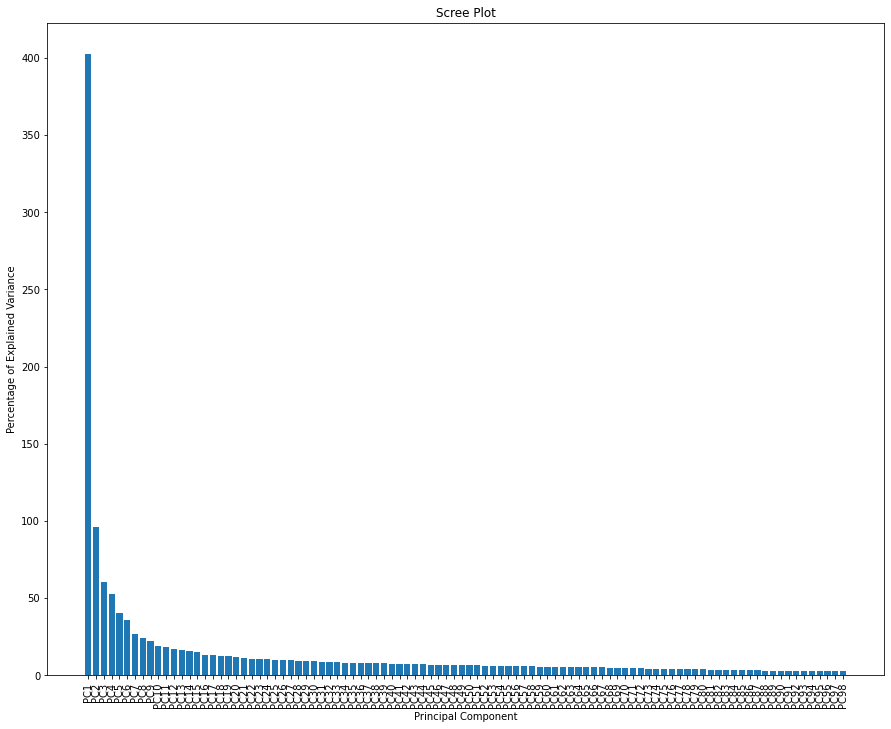

In [24]:
per_var = np.round(pca.explained_variance_ * 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.figure(figsize=(15, 12))
plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.xticks(rotation=90)
plt.title('Scree Plot')
plt.show()

Principle Components till the 7th seems to be okay.

In [0]:
propertiesDF = propertiesDF[[propertiesDF.columns[i] for i in range(0, 7)]]
propertiesDF.rename(columns={x:'PC' + str(x + 1) for x in propertiesDF.columns}, inplace=True)
propertiesDF['item_id'] = properties_encodedDF.item_id.values.tolist()
propertiesDF

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,item_id
0,4.268394,-1.117515,1.206825,-0.172555,0.081194,-0.669126,1.107799,5101
1,3.413863,-0.686380,-0.641919,-0.750758,-0.454301,-0.137428,0.744887,5416
2,2.702444,-0.564900,-1.323003,-0.419391,-0.561054,-0.186493,-0.106244,5834
3,2.748292,-1.495741,-0.442845,-0.446834,0.010141,-0.383106,-0.227180,5910
4,5.328236,-1.506881,0.795871,-0.618732,1.951469,0.604371,1.069449,6066
...,...,...,...,...,...,...,...,...
927137,-2.163794,-0.500680,0.119632,0.115698,0.330080,-0.030932,0.410116,11199990
927138,-2.163794,-0.500680,0.119632,0.115698,0.330080,-0.030932,0.410116,11236100
927139,-2.163794,-0.500680,0.119632,0.115698,0.330080,-0.030932,0.410116,11260526
927140,-2.163794,-0.500680,0.119632,0.115698,0.330080,-0.030932,0.410116,11263712


In [0]:
propertiesDF.to_csv('../TrivagoRecommenderSystem1/Datasets/clean_data/ItemsPropertiesSimilarities/PCA_Properties.csv', index=False)

In [0]:
propertiesDF = pd.read_csv('../TrivagoRecommenderSystem1/Datasets/clean_data/ItemsPropertiesSimilarities/PCA_Properties.csv')

Items' Properties were generated by two methods, the first one is the K-means which grouped items into 5 clusters, the second one is the PCA which got the principal components of the properties.  
The items' properties contain valuable information, and sure it helps in making the predictive power the model better.  
Concatenating these properties to the generated data above is the purpose of this step.

In [13]:
TrainKclusters = TrainMoreData.merge(ClusterDF, on='item_id', how='left').fillna(0)
TrainKclusters

,session_id,item_id,price,item_rank,price_rank,clickout,session_duration,item_duration,item_session_duration,item_interactions,maximum_step,top_list,NumberOfProperties,NumberInImpressions,NumberInReferences,NumberAsClickout,NumberAsFinalClickout,FClickoutToImpressions,FClickoutToReferences,FClickoutToClickout,MeanRank,MeanPrice,MaxPrice,MinPrice,AveragePriceRank,A,B,C,D,E
0,aff3928535f48,55109,162,1,8,0,1025,0.0,0.000000,0.0,16,1,58.0,584.0,479.0,25.0,11.0,0.018836,0.022965,0.440000,12.239726,194.595890,1905.0,65.0,11.840753,0.0,0.0,1.0,0.0,0.0
1,aff3928535f48,129343,25,2,1,0,1025,0.0,0.000000,0.0,16,1,26.0,108.0,69.0,9.0,4.0,0.037037,0.057971,0.444444,11.083333,72.259259,388.0,18.0,10.166667,0.0,0.0,0.0,1.0,0.0
2,aff3928535f48,54824,150,3,15,0,1025,0.0,0.000000,0.0,16,1,42.0,443.0,386.0,61.0,32.0,0.072235,0.082902,0.524590,11.627540,107.672686,408.0,42.0,11.291196,0.0,0.0,0.0,1.0,0.0
3,aff3928535f48,2297972,143,4,5,0,1025,0.0,0.000000,0.0,16,1,38.0,17.0,23.0,2.0,0.0,0.000000,0.000000,0.000000,13.294118,136.000000,183.0,101.0,9.647059,0.0,0.0,0.0,1.0,0.0
4,aff3928535f48,109014,101,5,12,0,1025,0.0,0.000000,0.0,16,1,60.0,194.0,268.0,18.0,9.0,0.046392,0.033582,0.500000,14.443299,149.329897,628.0,70.0,11.262887,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13192212,a4c049a08e9801,1425092,84,9,3,0,1037,0.0,0.000000,0.0,46,0,36.0,44.0,16.0,2.0,1.0,0.022727,0.062500,0.500000,14.931818,66.772727,156.0,54.0,11.500000,0.0,0.0,0.0,1.0,0.0
13192213,a4c049a08e9801,1627067,94,10,10,0,1037,13.0,0.012536,2.0,46,0,54.0,126.0,98.0,15.0,9.0,0.071429,0.091837,0.600000,12.349206,97.896825,216.0,59.0,11.031746,0.0,0.0,0.0,0.0,1.0
13192214,a4c049a08e9801,4201464,143,11,2,0,1037,152.0,0.146577,15.0,46,0,16.0,12.0,17.0,2.0,1.0,0.083333,0.058824,0.500000,15.416667,121.250000,158.0,92.0,8.000000,0.0,1.0,0.0,0.0,0.0
13192215,a4c049a08e9801,2106906,137,12,0,0,1037,0.0,0.000000,0.0,46,0,32.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,12.000000,137.000000,137.0,137.0,0.000000,0.0,0.0,0.0,0.0,1.0


In [0]:
TrainPCA = TrainMoreData.merge(propertiesDF, on='item_id', how='left').fillna(method='ffill')
TrainPCA